In [8]:
!pip install tensorflow_ranking

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, Dropout

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import sklearn
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import pickle

In [10]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [11]:
file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}.npy") # pre-filtered data is "windowed_filtered"
feature_x_data = np.load(f"data/processed/x_{file_name}_features.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy")
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy")

extra_x_data = np.load(f"data/generated_samples/0_mixed_with_other_gestures.npy")

print(extra_x_data.shape)

(500, 200, 16)


## Sample extra data points and turn them into features

In [12]:
from VAE import get_auth_model

model = get_auth_model((200,16))


auth_user is 0
DL


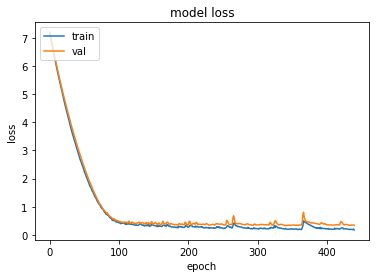

34/34 [==============================] - 1s 3ms/step
0.7724964258969297
Loss is 2.451188346023914


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


auth_user is 0
MLP
0.8405558799115105
Loss is 1.1778318158254186


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


auth_user is 0
SVM
0.8661154985192497
Loss is 1.1460062117511252


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


auth_user is 0
WatchAuth
0.8467784642541925
Loss is 1.0186603150406948


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

In [36]:
import datetime, csv, os, re, sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, f1_score, precision_score, precision_recall_curve, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold

from scaler import CustomScaler

#configs
maxprewindowsize = 4
classifier = 'rfc'

folds = 10


def get_average(l):
	return 0 if 0 == len(l) else sum(l) / len(l)

def get_eer(scores_legit, scores_adv):
	scores_legit = sorted(scores_legit)
	scores_adv = sorted(scores_adv)
	
	#treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr >= far:
			return threshold, far
	print("Failure")

def get_eer_recogblind(scores_legit, scores_adv_typed, total_w, total_b, total_i):
	scores_legit = sorted(scores_legit)
	scores_adv_typed = sorted(scores_adv_typed, key = lambda x:x[0])
	
	#treat each legitimate sample distance as a possible threshold, determine the point where FRR crosses FAR
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv_typed) if x[1][0] > threshold), len(scores_adv_typed))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr >= far:
			rejectrate_w = 0 if 0 == total_w else len([i for i in scores_adv_typed if 'W' == i[1] and i[0] >= threshold]) / total_w
			rejectrate_b = 0 if 0 == total_b else len([i for i in scores_adv_typed if 'B' == i[1] and i[0] >= threshold]) / total_b
			rejectrate_i = 0 if 0 == total_i else len([i for i in scores_adv_typed if 'I' == i[1] and i[0] >= threshold]) / total_i
			return threshold, far, rejectrate_w, rejectrate_b, rejectrate_i

def get_far_when_zero_frr(scores_legit, scores_adv):
	scores_legit = sorted(scores_legit)
	scores_adv = sorted(scores_adv)
	
	#treat each legitimate sample distance as a possible threshold, determine the point with the lowest FAR that satisfies the condition that FRR = 0
	for c, threshold in enumerate(scores_legit):
		frr = c * 1.0 / len(scores_legit)
		adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
		far = 1 - (adv_index * 1.0 / len(scores_adv))
		if frr > 0.001:
			return threshold, far

def plot_threshold_by_far_frr(scores_legit, scores_adv, far_theta):
	scores_legit = sorted(scores_legit)
	scores_adv = sorted(scores_adv)
	
	frr = []
	far = []
	thresholds = []
	for c, threshold in enumerate(scores_legit):
		frr.append((c * 1.0 / len(scores_legit)) * 100)
		adv_index = next((x[0] for x in enumerate(scores_adv) if x[1] > threshold), len(scores_adv))
		far.append((1 - (adv_index * 1.0 / len(scores_adv))) * 100)
		thresholds.append(threshold)
	plt.figure(figsize = (6, 6))
	#plt.rcParams.update({'font.size': fontsize_legends})
	plt.plot(thresholds, far, 'tab:blue', label = 'FAR')
	plt.plot(thresholds, frr, 'tab:orange', label = 'FRR')
	plt.ylabel('error rate (%)')
	plt.xlabel(r'decision threshold, $\theta$')
	plt.axvline(x = far_theta, c = 'red')
	plt.legend(loc = 'best')
	plt.tight_layout(pad = 0.05)
	plt.show()

def plot_threshold_by_precision_recall(labels_test, labels_scores):
	p, r, thresholds = precision_recall_curve(labels_test, labels_scores)
	plt.figure(figsize = (6, 6))
	#plt.rcParams.update({'font.size': fontsize_legends})
	plt.title('Precision and Recall Scores as a Function of the Decision Threshold', fontsize = 12)
	plt.plot(thresholds, p[:-1], 'tab:blue', label = 'precision')
	plt.plot(thresholds, r[:-1], 'tab:orange', label = 'recall')
	plt.ylabel('score')
	plt.xlabel(r'decision threshold, $\theta$')
	plt.legend(loc = 'best')
	plt.tight_layout(pad = 0.05)
	plt.show()

def plot_roc_curve(labels_test, labels_scores):
	fpr, tpr, auc_thresholds = roc_curve(labels_test, labels_scores)
	print('AUC of ROC = ' + str(auc(fpr, tpr)))
	plt.figure(figsize = (6, 6))
	#plt.rcParams.update({'font.size': fontsize_legends})
	plt.title('ROC Curve', fontsize = 12)
	plt.plot(fpr, tpr, 'tab:orange', label = 'recall optimized')
	plt.plot([0, 1], [0, 1], 'k--')
	plt.axis([-0.005, 1, 0, 1.005])
	plt.xticks(np.arange(0, 1, 0.05), rotation = 90)
	plt.xlabel('false positive rate')
	plt.ylabel('true positive rate (recall)')
	plt.legend(loc = 'best')
	plt.tight_layout(pad = 0.05)
	plt.show()

def get_ascending_userID_list_string():
	for u in userIDs:
		if not 'user' in u and len(u) != 7:
			sys.exit('ERROR: userID not valid: ' + str(u))
	IDs = [int(u[4:]) for u in userIDs]
	IDs.sort(reverse = False)
	return ','.join([f'{i:03}' for i in IDs])

def get_descending_feature_list_string(weights, labels, truncate = 0):
	indicies = [i for i in range(len(weights))]
	for i in range(len(indicies)):
		for j in range(len(indicies)):
			if i != j and weights[indicies[i]] > weights[indicies[j]]:
				temp = indicies[i]
				indicies[i] = indicies[j]
				indicies[j] = temp
	if truncate != 0:
		del indicies[truncate:]
	return '\n'.join([str('%.6f' % weights[i]) + ' (' + labels[i] + ')' for i in indicies])

def write_verbose(f, s):
	outfilename = f + '-verbose.txt'
	outfile = open(outfilename, 'a')
	outfile.write(s + '\n')
	outfile.close()

    
from featurize import filter
from sklearn.neural_network import MLPClassifier

feature_array = feature_x_data
    
output = {}

#auth_user = 3

train_data_map = train_gesture_map
test_data_map = test_gesture_map


repetitions = 1

for model_name in ["DL", "MLP", "SVM", "WatchAuth"]:

    for auth_user in range(1): # TODO - all 16 users


        print(f"auth_user is {auth_user}")

        key = str(auth_user) + "_" + model_name
        output[key] = {"fm":[], "prec":[], "rec":[], "eer":[], "far":[]}


        a_precisions = []
        a_recalls = []
        a_fmeasures = []
        a_pr_stdev = []
        a_re_stdev = []
        a_fm_stdev = []
        a_eers = []
        a_eer_thetas = []
        a_fars = []
        a_far_thetas = []
        a_ee_stdev = []
        a_ee_th_stdev = []
        a_fa_stdev = []
        a_fa_th_stdev = []


        train_data_map = train_data_map.astype(bool)
        test_data_map = test_data_map.astype(bool)
        

        #############

        feature_data_train = feature_array[train_data_map]
        data_train = x_data[train_data_map]
        labels_train = (y_user.argmax(axis=1) == auth_user)[train_data_map].astype(int)

        feature_data_test = feature_array[test_data_map]
        data_test = x_data[test_data_map]
        labels_test = (y_user.argmax(axis=1) == auth_user)[test_data_map].astype(int)

        

        for repetition in range(repetitions):
            print(model_name)
            if model_name == "DL":
                
                model = None
                model = get_auth_model((200,16))  # get_auth_model
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy")
                
                

                shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)
                
                #ORDER = 6
                #CUTOFF = 3.667
                #shuffled_data_train = filter(shuffled_data_train, list(range(16)), ORDER, CUTOFF)
                
                scaler = CustomScaler()
                shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)
                

                kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
                val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]

                
                early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=50,
                                                                           patience=100, restore_best_weights=True)

                
                
                model = get_auth_model((200,16))
                model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy")
                history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=1000,
                                    batch_size=128, verbose=0,
                                    validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                                   class_weight={0:0.5, 1:7.5},
                                   callbacks=[early_stopping_callback])
               
                plt.plot(history.history['loss'])
                plt.plot(history.history['val_loss'])
                plt.title('model loss')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.legend(['train', 'val'], loc='upper left')
                plt.show()

                plt.clf()
                
                labels_scores = model.predict(scaler.transform(data_test)).squeeze()
                labels_pred = (labels_scores >= 0.5).astype(int)
                
                
            
            elif model_name == "WatchAuth":
                model = RandomForestClassifier(n_estimators = 100, random_state = repetition, class_weight="balanced").fit(feature_data_train, labels_train)


                labels_pred = model.predict(feature_data_test)
                labels_scores = model.predict_proba(feature_data_test)[:, 1]
            
            elif model_name == "SVM":
                
                clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True, class_weight="balanced"))
                clf.fit(feature_x_data[train_data_map], labels_train)

                labels_pred = clf.predict(feature_x_data[test_data_map])
                labels_scores = clf.predict_proba(feature_data_test)[:, 1]
            
            elif model_name == "MLP":
            
                clf = make_pipeline(StandardScaler(), MLPClassifier(solver='lbfgs', alpha=1e-3,
                         hidden_layer_sizes=(50,20, 2), random_state=repetition)) # ,class_weight="balanced")) 
                clf.fit(feature_x_data[train_data_map], labels_train)

                labels_pred = clf.predict(feature_x_data[test_data_map])
                labels_scores = clf.predict_proba(feature_data_test)[:, 1]

            #get precision, recall, and F-measure scores
            precision = precision_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
            recall = recall_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
            fmeasure = f1_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred)) # macro vs binary
            a_precisions.append(precision)
            a_recalls.append(recall)
            a_fmeasures.append(fmeasure)
            print(fmeasure)
            
            print(f"Loss is {sklearn.metrics.log_loss(labels_test, labels_pred)}")
            #print(precision)
            #print(recall)
            
            
            scores_legit = [labels_scores[i] for i in range(len(labels_test)) if 1 == labels_test[i]]
            scores_adv = [labels_scores[i] for i in range(len(labels_test)) if 0 == labels_test[i]]
            eer_theta, eer = get_eer(scores_legit, scores_adv)
            far_theta, far = get_far_when_zero_frr(scores_legit, scores_adv)

            #plot_roc_curve(labels_test, labels_scores)
            #plot_threshold_by_precision_recall(labels_test, labels_scores)
            #plot_threshold_by_far_frr(scores_legit, scores_adv, far_theta)

            #print(f"eer is {eer}")
            a_eers.append(eer)
            a_eer_thetas.append(eer_theta)
            a_fars.append(far)
            a_far_thetas.append(far_theta)



        a_pr_stdev = np.std(a_precisions, ddof = 1)
        a_re_stdev = np.std(a_recalls, ddof = 1)
        a_fm_stdev = np.std(a_fmeasures, ddof = 1)
        a_ee_stdev = np.std(a_eers, ddof = 1)
        a_ee_th_stdev = np.std(a_eer_thetas, ddof = 1)
        a_fa_stdev = np.std(a_fars, ddof = 1)
        a_fa_th_stdev = np.std(a_far_thetas, ddof = 1)


        output[key]["fm"] = (get_average(a_fmeasures), a_fm_stdev)
        output[key]["prec"] = (get_average(a_precisions), a_pr_stdev)
        output[key]["rec"] = (get_average(a_recalls), a_re_stdev)
        output[key]["eer"] = (get_average(a_eers), a_ee_stdev)
        output[key]["far"] = (get_average(a_fars), a_fa_stdev)

        import pickle

        with open(f'data/stats/multiple_models_scaled_v2.pickle', 'wb') as handle:
            pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
output
for stat in ["fm", "prec", "rec", "eer", "far"]:
    for model_name in ["DL", "MLP","SVM", "WatchAuth"]:
        l = []
        for auth_user in range(1):
            l.append(output[f"{auth_user}_{model_name}"][stat][0])
        print(model_name, stat, sum(l) /1)
    print("")

DL fm 0.7724964258969297
MLP fm 0.8405558799115105
SVM fm 0.8661154985192497
WatchAuth fm 0.8467784642541925

DL prec 0.7179537738760674
MLP prec 0.8541728615323619
SVM prec 0.8325248756218906
WatchAuth prec 0.9118822446332175

DL rec 0.8890640303623898
MLP rec 0.8281020445641528
SVM rec 0.9091423849167483
WatchAuth rec 0.8012594882468169

DL eer 0.12634671890303628
MLP eer 0.04701273261508321
SVM eer 0.046033300685602296
WatchAuth eer 0.05974534769833495

DL far 0.4397649363369246
MLP far 0.08619000979431934
SVM far 0.08423114593535752
WatchAuth far 0.10871694417237998



In [6]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=28bbe17021265bf9571e568d25d9bdcd31cc8b30a817937a17008a8394938a77
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [9]:




train_data_map = train_gesture_map.astype(bool)

labels_train = (y_user.argmax(axis=1) == 0)[train_data_map].astype(int)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(feature_x_data[train_data_map], labels_train)

labels_pred= clf.predict(feature_x_data[test_gesture_map.astype(bool)])

labels_score = model.predict_proba(feature_x_data[test_gesture_map.astype(bool)])


labels_test = (y_user.argmax(axis=1) == 0)[test_gesture_map.astype(bool)]

precision = precision_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
recall = recall_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
fmeasure = f1_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))

print(precision)
print(recall)
print(fmeasure)

AttributeError: 'Functional' object has no attribute 'predict_proba'

0
Epoch 1/1000
4/4 [==============================] - 8s 463ms/step - loss: 0.5721 - val_loss: 0.6657
Epoch 2/1000
4/4 [==============================] - 0s 72ms/step - loss: 0.5590 - val_loss: 0.6573
Epoch 3/1000
4/4 [==============================] - 0s 69ms/step - loss: 0.5442 - val_loss: 0.6454
Epoch 4/1000
4/4 [==============================] - 0s 66ms/step - loss: 0.5468 - val_loss: 0.6283
Epoch 5/1000
4/4 [==============================] - 0s 67ms/step - loss: 0.5378 - val_loss: 0.6067
Epoch 6/1000
4/4 [==============================] - 0s 66ms/step - loss: 0.5220 - val_loss: 0.5870
Epoch 7/1000
4/4 [==============================] - 0s 66ms/step - loss: 0.5223 - val_loss: 0.5714
Epoch 8/1000
4/4 [==============================] - 0s 65ms/step - loss: 0.5072 - val_loss: 0.5581
Epoch 9/1000
4/4 [==============================] - 0s 65ms/step - loss: 0.4868 - val_loss: 0.5443
Epoch 10/1000
4/4 [==============================] - 0s 92ms/step - loss: 0.4703 - val_loss: 0.5276
Epoch 

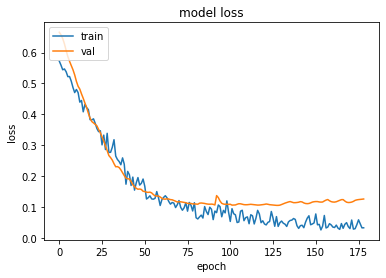

<Figure size 432x288 with 0 Axes>

In [38]:
feature_array = feature_x_data
train_data_map = train_gesture_map.astype(bool)
test_data_map = test_gesture_map.astype(bool)

class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, layers):
        super(SplitLayer, self).__init__()
        self.layers = layers

    def call(self, inputs):
        return tf.gather(inputs,indices=self.layers,axis=-1)


def get_new_auth_model(input_dim=(200,16)):
    #input_dim = (200,16)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    
    layers_1d = [  Reshape((200, 1)),
                   Conv1D(100, 5, strides=2, padding="same"),
                   MaxPooling1D(pool_size=2, strides=None, padding="same"),
                   Conv1D(100, 3, strides=1, padding="same"),
                   MaxPooling1D(pool_size=2, strides=None, padding="same")]
    
    xs = []
    
    for i in range(16):
        x_1d = SplitLayer(i)(x)
        
        for layer in layers_1d:
            x_1d = layer(x_1d)
        xs.append(x_1d)
    
    x = layers.Concatenate()(xs)
    
    x = LSTM(50)(x)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    #x = layers.Lambda(lambda x: x / 2)
    out = x

    model = keras.Model(inputs, out, name="LSTM_classifier_v2")
    
    return model

min_val_loss = []


for auth_user in range(1):
    
    print(auth_user)
    
    feature_data_train = feature_array[train_data_map]
    data_train = x_data[train_data_map]
    labels_train = (y_user.argmax(axis=1) == auth_user)[train_data_map].astype(int)
    

    scaler = CustomScaler()
    
    shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)
    
    shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)
    
    kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
    val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=50,
                                                                           patience=50, restore_best_weights=True)
    
    #scaler = CustomScaler()

    model = get_new_auth_model()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy")
    history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=1000,
                        batch_size=128, verbose=1,
                        validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                       class_weight={0:0.5, 1:7.5},
                       callbacks=[early_stopping_callback])
    
    min_val_loss.append(np.argmin(history.history['val_loss']))
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.clf()

In [39]:
data_test = x_data[test_data_map]
labels_train = (y_user.argmax(axis=1) == auth_user)[test_data_map].astype(int)

labels_scores = model.predict(scaler.transform(data_test)).squeeze()
labels_pred = (labels_scores >= 0.5).astype(int)

precision = precision_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
recall = recall_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
fmeasure = f1_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))

print(precision, recall, fmeasure, sklearn.metrics.log_loss(labels_test, labels_pred))

34/34 [==============================] - 1s 10ms/step
0.7906964380648591 0.9184010773751224 0.8405155293683482 1.4961785021756504


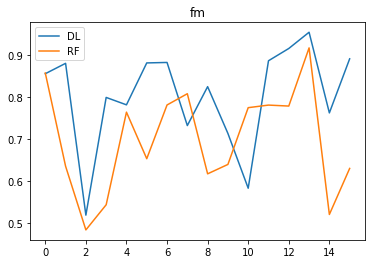

DL: 0.8031665214250959
RF: 0.6983209566008504


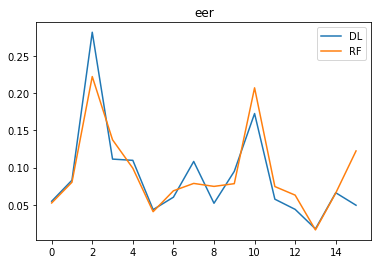

DL: 0.08784750344927238
RF: 0.092546523931679


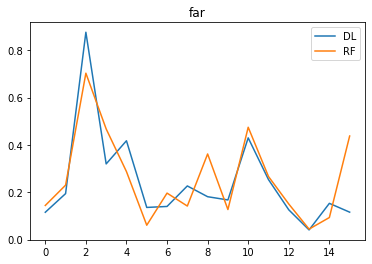

DL: 0.243050540259631
RF: 0.26135640499228796


In [ ]:
import pickle#

#with open(f'watch_auth_stats_DL_auth_v2.pickle', 'rb') as handle:
#    output2 = pickle.load(handle)
    
#print(output2)



"""
binary - 
{'0_True': {'fm': [0.7894317424545334],
  'prec': [0.8334041195917907],
  'rec': [0.75],
  'eer': [0.042703232125367294],
  'far': [0.11283055827619984]},
 '0_False': {'fm': [0.736116623010689],
  'prec': [0.8684356447481862],
  'rec': [0.6390625],
  'eer': [0.0544564152791381],
  'far': [0.16474045053868752]}}
"""
vals = []
for k in output:
    vals.append(output[k]["fm"][0])
plt.plot(vals[:16], label="DL")
plt.plot(vals[16:], label="RF")
plt.legend()
plt.title("fm")
plt.show()

print("DL:", sum(vals[:16])/16)
print("RF:", sum(vals[16:])/16)

"""
DL: 0.8031665214250959
RF: 0.6983209566008504
"""


vals = []
for k in output:
    vals.append(output[k]["eer"][0])
plt.plot(vals[:16], label="DL")
plt.plot(vals[16:], label="RF")
plt.legend()
plt.title("eer")
plt.show()

print("DL:", sum(vals[:16])/16)
print("RF:", sum(vals[16:])/16)

"""
DL: 0.08784750344927238
RF: 0.092546523931679
"""

vals = []
for k in output:
    vals.append(output[k]["far"][0])
plt.plot(vals[:16], label="DL")
plt.plot(vals[16:], label="RF")
plt.legend()
plt.title("far")
plt.show()

print("DL:", sum(vals[:16])/16)
print("RF:", sum(vals[16:])/16)

"""
DL: 0.243050540259631
RF: 0.26135640499228796
"""



In [68]:

list(zip(labels_test, model.predict_proba(data_test)[:,1]))

[(1, 0.81),
 (1, 0.51),
 (1, 0.72),
 (1, 0.71),
 (1, 0.81),
 (1, 0.79),
 (1, 0.89),
 (1, 0.83),
 (1, 0.26),
 (1, 0.19),
 (1, 0.04),
 (1, 0.08),
 (1, 0.52),
 (1, 0.27),
 (1, 0.15),
 (1, 0.08),
 (1, 0.12),
 (1, 0.12),
 (1, 0.44),
 (1, 0.38),
 (1, 0.37),
 (1, 0.26),
 (1, 0.69),
 (1, 0.37),
 (1, 0.52),
 (1, 0.56),
 (1, 0.88),
 (1, 0.48),
 (1, 0.75),
 (1, 0.04),
 (1, 0.14),
 (1, 0.17),
 (1, 0.0),
 (1, 0.02),
 (1, 0.02),
 (1, 0.18),
 (1, 0.11),
 (1, 0.09),
 (1, 0.06),
 (1, 0.04),
 (1, 0.1),
 (1, 0.06),
 (1, 0.24),
 (1, 0.08),
 (1, 0.04),
 (1, 0.07),
 (1, 0.06),
 (1, 0.01),
 (1, 0.03),
 (1, 0.0),
 (1, 0.0),
 (1, 0.07),
 (1, 0.03),
 (1, 0.58),
 (1, 0.42),
 (1, 0.75),
 (1, 0.58),
 (1, 0.69),
 (1, 0.04),
 (1, 0.17),
 (1, 0.06),
 (1, 0.64),
 (1, 0.13),
 (1, 0.07),
 (1, 0.71),
 (1, 0.51),
 (1, 0.42),
 (1, 0.73),
 (1, 0.11),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.0),
 (0, 0.01),
 (0, 0.0),
 (0, 0.0),
 (0, 0.01),
 (0, 0.01),
 (0, 0.0),
 (0, 0.0),
 (0, 0.01),
 (0, 0.0),
 (0, 0.01),
 (0, 0

In [7]:
eer_theta

0.14653307

In [7]:
for user in range(16):
    print(sum((y_intent == 1) & (y_user.argmax(axis=1) == user)))

209
206
261
194
923
225
206
223
139
136
219
271
231
254
244
254


In [23]:
precision = precision_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
recall = recall_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))
fmeasure = f1_score(labels_test, labels_pred, average = 'macro', labels = np.unique(labels_pred))


print(precision)
print(recall)
print(fmeasure)

print(np.unique(labels_test,return_counts=True))
print(np.unique(labels_pred,return_counts=True))

NameError: name 'labels_pred' is not defined

## VAE with multiple outputs from latent space

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, _classifier = None, _auth = None, beta = 0.001, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.classifier = _classifier
        self.auth = _auth
        #self.classifier = keras.models.load_model(f'data/models/{model_name}.hdf5')

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.feature_loss_tracker = keras.metrics.Mean(
            name="feature_loss"
        )
        self.classification_loss_tracker = keras.metrics.Mean(
            name="classification_loss"
        )
        self.reencoding_loss_tracker = keras.metrics.Mean(
            name="reencoding_loss"
        )
        self.auth_loss_tracker = keras.metrics.Mean(name="auth_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.beta = beta

    def save_model(self, folder, tag):
        
        with open(f'data/models/{folder}/enc_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.encoder, f)

        with open(f'data/models/{folder}/dec_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.decoder, f)

        with open(f'data/models/{folder}/auth_{tag}.pickle', 'wb') as f:
            # Pickle the 'data' dictionary using the highest protocol available.
            pickle.dump(self.auth, f)
    
    def load_model(self, folder, tag):
        
        with tf.keras.utils.custom_object_scope({'Sampling': Sampling}):
            with open(f'data/models/{folder}/enc_{tag}.pickle', 'rb') as pickle_file:
                self.encoder = pickle.load(pickle_file)
            with open(f'data/models/{folder}/dec_{tag}.pickle', 'rb') as pickle_file:
                self.decoder = pickle.load(pickle_file)
            with open(f'data/models/{folder}/auth_{tag}.pickle', 'rb') as pickle_file:
                self.auth = pickle.load(pickle_file)
        
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.feature_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        data, y_user_one_hot = data
        print(data)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            #data_probability = self.classifier(data)
            #reconstruction_probability = self.classifier(reconstruction)
            #classification_loss = tf.reduce_mean(abs(data_probability - reconstruction_probability))

            reconstruction_loss = tf.reduce_mean(keras.losses.mse(data, reconstruction), axis=1) # * data_probability
            
            #re_encoded, _, _ = self.encoder(reconstruction)
            #reencoding_loss = tf.reduce_mean(keras.losses.mse(z_mean, re_encoded))
            
            #feature_loss = tf.reduce_mean(keras.losses.MeanAbsolutePercentageError(self.batch_features(data), self.batch_features(reconstruction)))
            
            feature_loss = 0.5 * (tf.reduce_mean(keras.losses.mse(self.rolling_max(data), self.rolling_max(reconstruction))) + 
                                          tf.reduce_mean(keras.losses.mse(self.rolling_min(data), self.rolling_min(reconstruction))) )

            #reconstruction_loss = tf.reduce_mean(keras.losses.mean_absolute_error(data, reconstruction), axis=1)
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            auth_output = self.auth(z)
            
            auth_loss = tfr.keras.losses.ApproxMRRLoss()(y_user_one_hot, auth_output) ## TODO - figure out how to get true values in here

            sample_loss = 0.5 * reconstruction_loss + 0.5 * feature_loss #+ 0.0 * feature_loss
            
            total_loss = auth_loss + sample_loss + self.beta * kl_loss #+ classification_loss # + 0.1*feature_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.auth_loss_tracker.update_state(auth_loss)
        #self.feature_loss_tracker.update_state(feature_loss)
        #self.reencoding_loss_tracker.update_state(reencoding_loss)
        #self.classification_loss_tracker.update_state(classification_loss) #
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "classification_loss": self.classification_loss_tracker.result(),
            "feature_loss"       : self.feature_loss_tracker.result(),
            "auth_loss": self.auth_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def batch_features(self, x):
        feature_list = []
        #_max = tf.math.reduce_max(x, axis=1)
        #_min = tf.math.reduce_min(x, axis=1)
        _segment_max = self.rolling_max(x)
        _segment_min = self.rolling_min(x)
        _range = _segment_max - _segment_min
        
        _mean = tf.math.reduce_mean(_range, axis=0)
        _std = tf.math.reduce_std(_range, axis=0)
        
        return [ _mean, _std] # _max, _min,


    def rolling_max(self, x):
        return tf.nn.pool(
            x,
            (5,),
            "MAX",
            strides=(1,),
            padding='VALID'
        )
    
    def rolling_min(self, x):
        return -tf.nn.pool(
            -x,
            (5,),
            "MAX",
            strides=(1,),
            padding='VALID'
        )
        
    def rolling_mean(self, x):
        return tf.nn.pool(
            x,
            (5,),
            "MEAN",
            strides=(5,),
            padding='VALID'
        )
        

In [14]:
auth_user = 15
auth_map = (y_intent == 1) & (y_user.argmax(axis=1) != auth_user)


weighted_auth_data = np.concatenate([unweighted_data[y_user.argmax(axis=1) != auth_user]] + [unweighted_data[auth_map] for i in range(20)])
weighted_y_auth_data = np.concatenate([y_user[y_user.argmax(axis=1) != auth_user]] + [y_user[auth_map] for i in range(20)])

vae = VAE(None, None, None)
vae.load_model("no_15", "all_data")

opt = keras.optimizers.Adam()



NameError: name 'unweighted_data' is not defined